# Imports and helper functions


In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 19.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

# Libraries to define the required functions
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen

from pmdarima.model_selection import train_test_split as time_train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn import metrics
from sklearn.model_selection import ParameterGrid

from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from pmdarima import auto_arima


import warnings
warnings.filterwarnings("ignore")

In [ ]:
def mean_absolute_percentage_error_func(y_true, y_pred):
    '''
    Calculate the mean absolute percentage error as a metric for evaluation
    
    Args:
        y_true (float64): Y values for the dependent variable (test part), numpy array of floats 
        y_pred (float64): Predicted values for the dependen variable (test parrt), numpy array of floats
    
    Returns:
        Mean absolute percentage error 
    '''    
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    '''
    Calculate the following evaluation metrics:
        - MAE
        - MSE
        - RMSE
        - MAPE
        - R²
    
    Args:
        y_true (float64): Y values for the dependent variable (test part), numpy array of floats 
        y_pred (float64): Predicted values for the dependen variable (test parrt), numpy array of floats
    
    Returns:
        MAE, MSE, RMSE, MAPE and R² 
    '''    
    print('Evaluation metric results: ')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error_func(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [ ]:
def Augmented_Dickey_Fuller_Test_func(timeseries , column_name):
    '''
    Calculates statistical values whether the available data are stationary or not 
    
    Args:
        series (float64): Values of the column for which stationarity is to be checked, numpy array of floats 
        column_name (str): Name of the column for which stationarity is to be checked
    
    Returns:
        p-value that indicates whether the data are stationary or not
    ''' 
    print (f'Results of Dickey-Fuller Test for column: {column_name}')
    adfTest = adfuller(timeseries, autolag='AIC')
    dfResults = pd.Series(adfTest[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])
    for key, value in adfTest[4].items():
       dfResults['Critical Value (%s)'%key] = value
    print (dfResults)
    if adfTest[1] <= 0.05:
        print()
        print("Conclusion:")
        print("Reject the null hypothesis")
        print('\033[92m' + "Data is stationary" + '\033[0m')
    else:
        print()
        print("Conclusion:")
        print("Fail to reject the null hypothesis")
        print('\033[91m' + "Data is non-stationary" + '\033[0m')

In [ ]:
def cointegration_test_func(df): 
    '''
    Test if there is a long-run relationship between features
    
    Args:
        dataframe (float64): Values of the columns to be checked, numpy array of floats 
    
    Returns:
        True or False whether a variable has a long-run relationship between other features
    ''' 
    johansen_cointegration_test = coint_johansen(df,-1,5)
    c = {'0.90':0, '0.95':1, '0.99':2}
    traces = johansen_cointegration_test.lr1
    cvts = johansen_cointegration_test.cvt[:, c[str(1-0.05)]]
    def adjust(val, length= 6): 
        return str(val).ljust(length)
    print('Column_Name  >  Test_Stat  >  C(95%)  =>  Signif  \n', '--'*25)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), '  >  ', 
              adjust(round(trace,2), 9), "  >  ", 
              adjust(cvt, 8), '  => ' , 
              trace > cvt)

In [ ]:
def inverse_diff_func(actual_df, pred_df):
    '''
    Transforms the differentiated values back
    
    Args:
        actual dataframe (float64): Values of the columns, numpy array of floats 
        predicted dataframe (float64): Values of the columns, numpy array of floats 
    
    Returns:
        Dataframe with the predicted values
    '''
    df_temp = pred_df.copy()
    columns = actual_df.columns
    for col in columns: 
        df_temp[str(col)+'_inv_diff'] = actual_df[col].iloc[-1] + df_temp[str(col)].cumsum()
    return df_temp

# Model

In [ ]:
df_raw = pd.read_csv("/content/national_illness.csv").set_index('date')

In [ ]:
df_raw

,% WEIGHTED ILI,%UNWEIGHTED ILI,AGE 0-4,AGE 5-24,ILITOTAL,NUM. OF PROVIDERS,OT
date,,,,,,,
2002-01-01 00:00:00,1.222620,1.166680,582,805,2060,754,176569
2002-01-08 00:00:00,1.333440,1.216500,683,872,2267,785,186355
2002-01-15 00:00:00,1.319290,1.130570,642,878,2176,831,192469
2002-01-22 00:00:00,1.494840,1.252460,728,1045,2599,863,207512
2002-01-29 00:00:00,1.471950,1.302370,823,1189,2907,909,223208
...,...,...,...,...,...,...,...
2020-06-02 00:00:00,0.839059,0.846722,2756,3528,12913,3258,1525058
2020-06-09 00:00:00,0.895958,0.908885,3203,3778,13979,3254,1538038
2020-06-16 00:00:00,0.910926,0.941625,3478,3796,14389,3177,1528103


In [ ]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 966 entries, 2002-01-01 00:00:00 to 2020-06-30 00:00:00
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   % WEIGHTED ILI     966 non-null    float64
 1   %UNWEIGHTED ILI    966 non-null    float64
 2   AGE 0-4            966 non-null    int64  
 3   AGE 5-24           966 non-null    int64  
 4   ILITOTAL           966 non-null    int64  
 5   NUM. OF PROVIDERS  966 non-null    int64  
 6   OT                 966 non-null    int64  
dtypes: float64(2), int64(5)
memory usage: 92.7+ KB


In [ ]:
df_raw.describe()

,% WEIGHTED ILI,%UNWEIGHTED ILI,AGE 0-4,AGE 5-24,ILITOTAL,NUM. OF PROVIDERS,OT
count,966.000000,966.000000,966.000000,966.000000,966.000000,966.000000,9.660000e+02
mean,1.851286,1.845240,3434.813665,4981.128364,13540.716356,1608.261905,6.514975e+05
std,1.343042,1.309019,3153.962885,5953.881662,15010.894094,681.580042,3.490189e+05
min,0.351881,0.491507,98.000000,91.000000,318.000000,264.000000,6.469900e+04
25%,0.971185,0.978537,1487.000000,1667.500000,4915.000000,1238.000000,3.853698e+05
50%,1.375970,1.359065,2552.000000,3265.500000,9028.500000,1501.500000,6.183050e+05
75%,2.291583,2.223535,4457.750000,5673.500000,16243.750000,1990.000000,8.134695e+05
max,7.715100,7.780900,24097.000000,45513.000000,111361.000000,3453.000000,1.640587e+06


# EDA

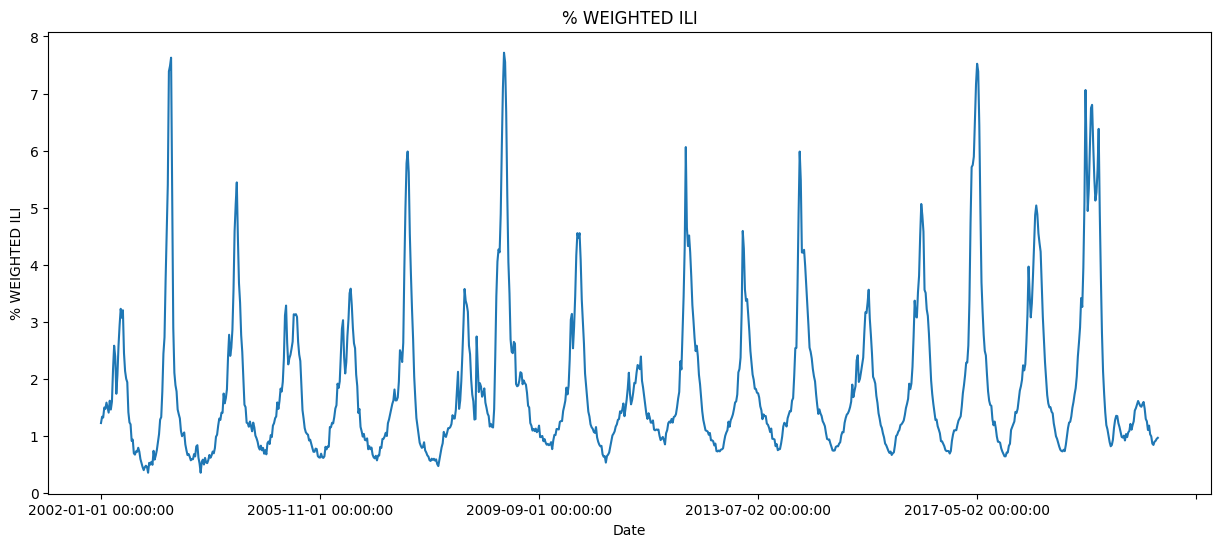

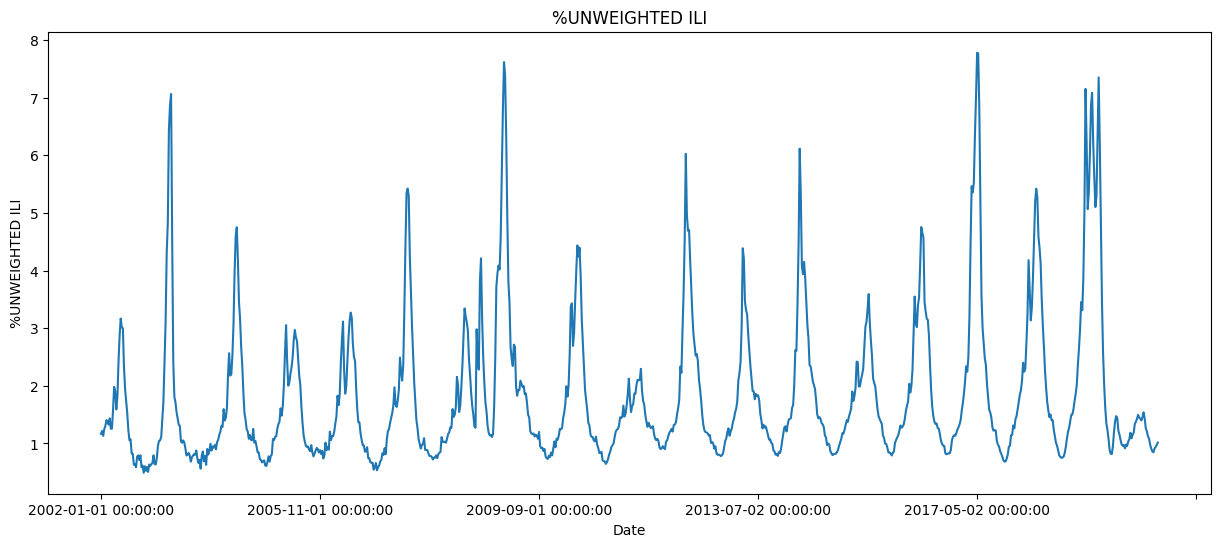

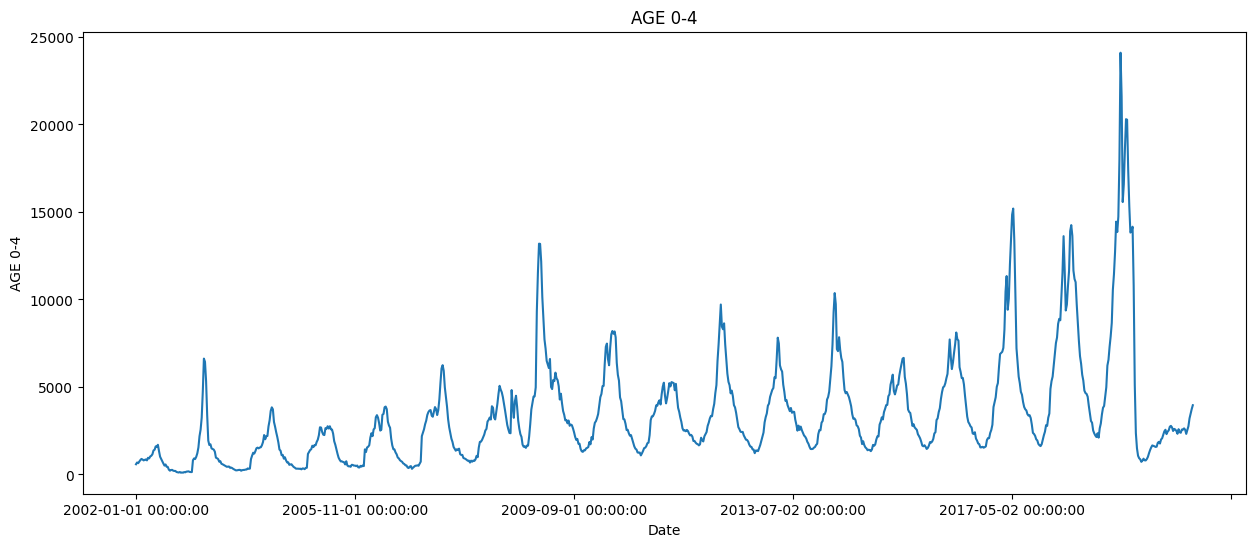

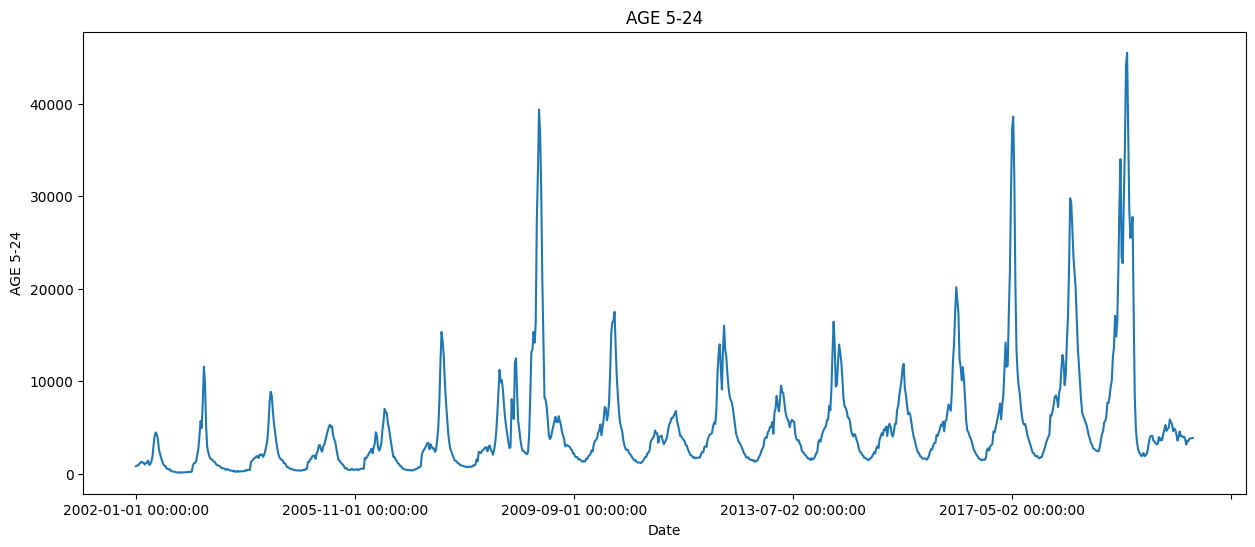

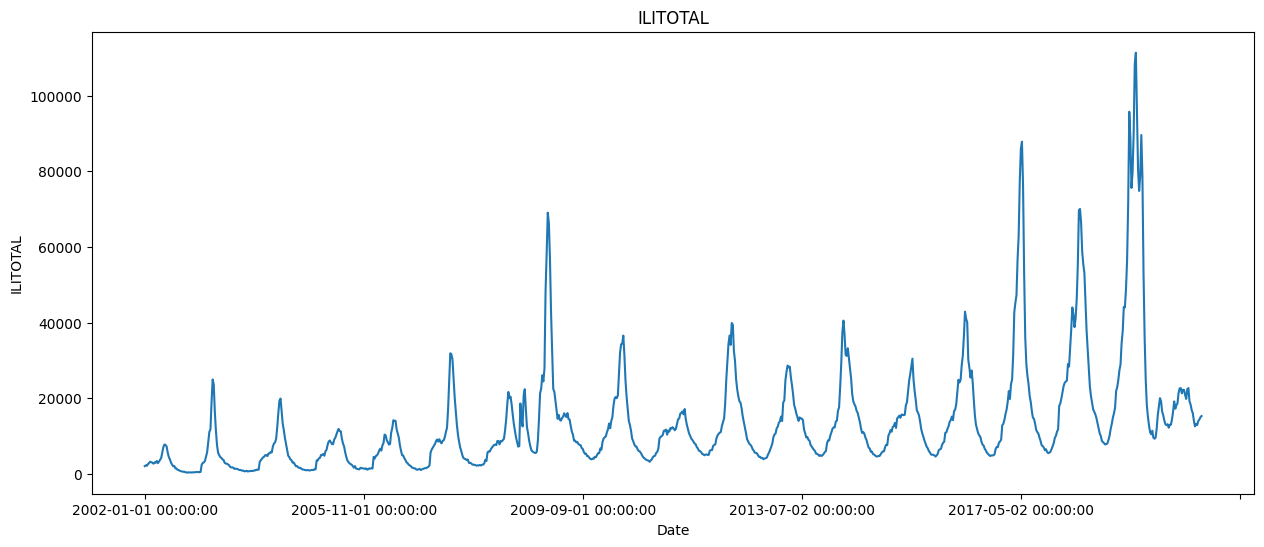

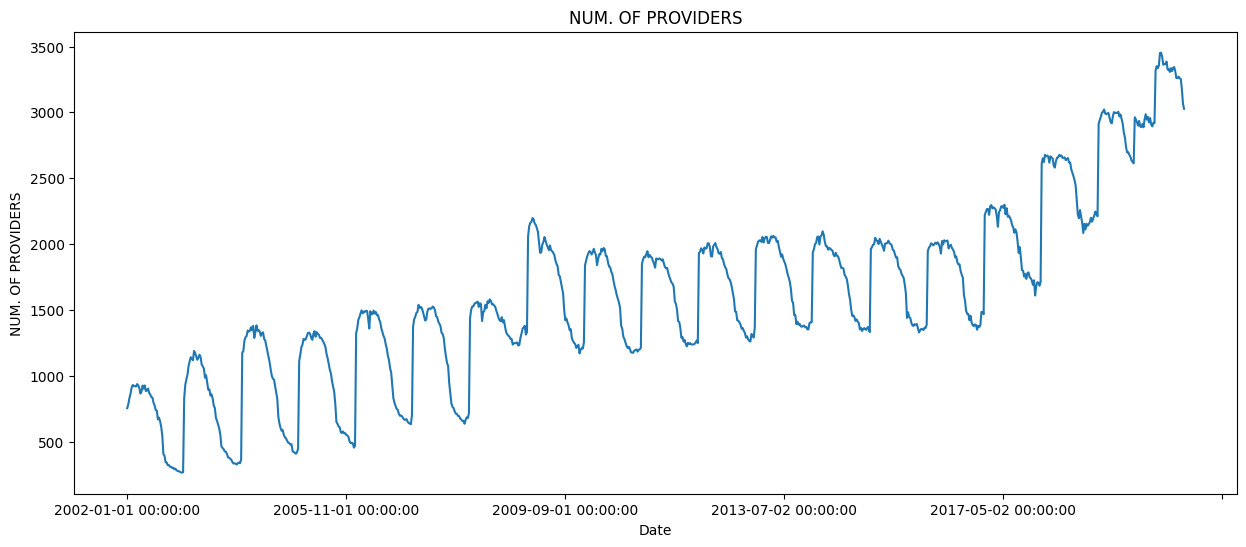

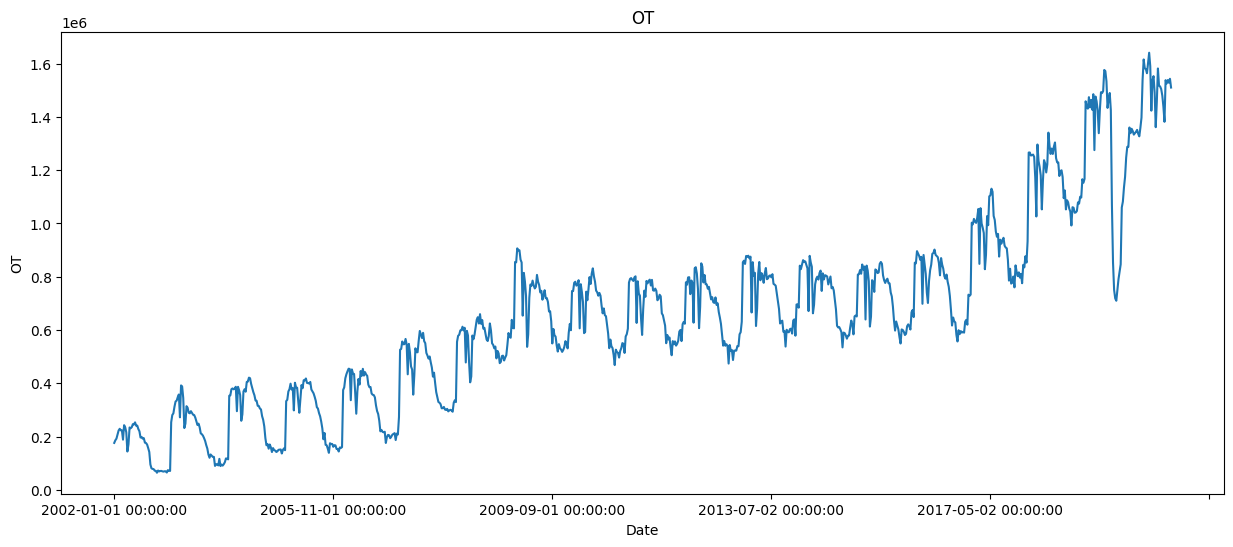

In [ ]:
for feature in df_raw.columns:
    df_raw[str(feature)].plot(figsize=(15, 6))
    plt.xlabel("Date")
    plt.ylabel(feature)
    plt.title(f"{str(feature)}")
    plt.show()

## Check for stationarity

In [ ]:
for name, column in df_raw[['% WEIGHTED ILI', '%UNWEIGHTED ILI', 'AGE 0-4', 'AGE 5-24', 'ILITOTAL', 'NUM. OF PROVIDERS', 'OT']].iteritems():
    Augmented_Dickey_Fuller_Test_func(df_raw[name],name)
    print('\n')

Results of Dickey-Fuller Test for column: % WEIGHTED ILI
ADF Test Statistic     -7.846482e+00
P-Value                 5.751031e-12
# Lags Used             1.100000e+01
# Observations Used     9.540000e+02
Critical Value (1%)    -3.437223e+00
Critical Value (5%)    -2.864574e+00
Critical Value (10%)   -2.568386e+00
dtype: float64

Conclusion:
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column: %UNWEIGHTED ILI
ADF Test Statistic     -7.746521e+00
P-Value                 1.028511e-11
# Lags Used             1.400000e+01
# Observations Used     9.510000e+02
Critical Value (1%)    -3.437245e+00
Critical Value (5%)    -2.864584e+00
Critical Value (10%)   -2.568391e+00
dtype: float64

Conclusion:
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column: AGE 0-4
ADF Test Statistic     -6.507123e+00
P-Value                 1.123931e-08
# Lags Used             1.400000e+01
# Observations Used     9.510000e+02
Critical Value (1

## Split into Train and Test

In [ ]:
X = df_raw.copy()

pred_len = [24, 36, 48, 60]

train, test = time_train_test_split(X, test_size=pred_len[0])

## Make it stationary

In [ ]:
train_diff = train.diff()
train_diff.iloc[0] = train.iloc[0]

In [ ]:
for name, column in train_diff.iteritems():
    Augmented_Dickey_Fuller_Test_func(train_diff[name],name)
    print('\n')

## Cointegreation test

In [ ]:
#cointegration_test_func(train_diff)
cointegration_test_func(df_raw)

Column_Name  >  Test_Stat  >  C(95%)  =>  Signif  
 --------------------------------------------------
% WEIGHTED ILI   >   458.26      >   111.7797   =>  True
%UNWEIGHTED ILI   >   325.58      >   83.9383    =>  True
AGE 0-4   >   205.26      >   60.0627    =>  True
AGE 5-24   >   125.75      >   40.1749    =>  True
ILITOTAL   >   50.57       >   24.2761    =>  True
NUM. OF PROVIDERS   >   11.38       >   12.3212    =>  False
OT       >   0.13        >   4.1296     =>  False


## Hyperparameter tuning

In [ ]:
def find_order_param_grid(X, y):
  param_grid = {'p': [1,2,3], 'q':[1,2,3]}
  pg = list(ParameterGrid(param_grid))

  df_results = pd.DataFrame(columns=['p', 'q','mae','mse'])
  print('Starting grid search...')
  for a,b in enumerate(pg):
    p = b.get('p')
    q = b.get('q')
    #if (p==2 and q==1) or (p==1 and q==2):
     # pass
    #else:
    print(f'Order: p={p}, q={q}')
    model_fit = VARMAX(X, order=(p,q)).fit()
    result = model_fit.forecast(len(y))

    mae = mean_absolute_error(y['OT'], result['OT'])
    mse = mean_squared_error(y['OT'], result['OT'])

    df_results = df_results.append({'p': p, 'q': q, 'mae': mae, 'mse': mse}, ignore_index=True)

  return list(df_results.sort_values('mae', ascending=True)[['p', 'q']].iloc[0])

In [ ]:
optimal_order = find_order_param_grid(train, test)  

## Fit model

In [ ]:
model = VARMAX(train_diff, order=optimal_order).fit(disp=False)

In [ ]:
result = model.forecast(steps = len(test))

print(f'Evaluation metric for OT:')
timeseries_evaluation_metrics_func(test['OT'] , result['OT'].values)

AutoARIMA:
Evaluation metric for OT:
Evaluation metric results: 
MAE is : 100598.67974575581
MSE is : 14338031321.524637
RMSE is : 119741.51878744748
MAPE is : 6.833271688815827
R2 is : -2.2836664107679154

GridSearch:
Evaluation metric for OT:
Evaluation metric results: 
MAE is : 165868.01927967824
MSE is : 32911864258.998493
RMSE is : 181416.27341282947
MAPE is : 11.169030144408453
R2 is : -6.537407385962846



In [ ]:
results = pd.read_csv('/content/results_VARMA_raw_national_illness.csv')

In [ ]:
results = pd.read_csv('/content/results_VARMA_raw_national_illness.csv')
results.columns

Index(['% WEIGHTED ILI', '%UNWEIGHTED ILI', 'AGE 0-4', 'AGE 5-24', 'ILITOTAL',
       'NUM. OF PROVIDERS', 'OT', 'forecast_24', 'residuals_24', 'forecast_36',
       'residuals_36', 'forecast_48', 'residuals_48', 'forecast_60',
       'residuals_60'],
      dtype='object')

In [ ]:
# Add best df to ILI data
results['date'] = df_raw.index
residual_df = results[['date', '% WEIGHTED ILI', '%UNWEIGHTED ILI', 'AGE 0-4', 'AGE 5-24', 'ILITOTAL', 'NUM. OF PROVIDERS', 'residuals_24', 'OT']].rename(columns={'residuals_24': 'RESIDUALS'})
all_residual_df = results[['date', '% WEIGHTED ILI', '%UNWEIGHTED ILI', 'AGE 0-4', 'AGE 5-24', 'ILITOTAL', 'NUM. OF PROVIDERS', 'residuals_24', 'residuals_36', 'residuals_48', 'residuals_60', 'OT']]

In [ ]:
residual_df

In [ ]:
all_residual_df.to_csv("national_illness_VARMA_all_Residuals.csv", index=False)

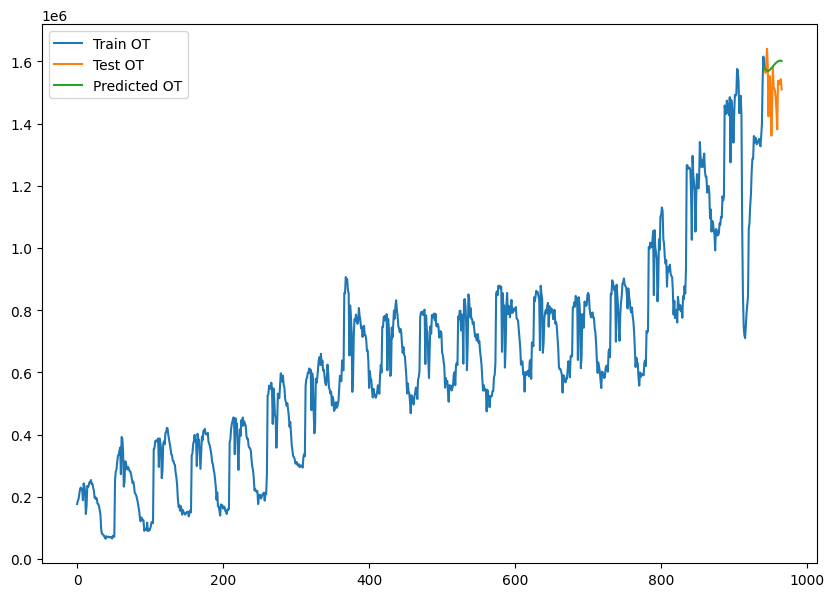

In [ ]:
plt.rcParams["figure.figsize"] = [10,7]
plt.plot(results['OT'][:-24], label='Train OT')
plt.plot(results['OT'][-24:], label='Test OT')
plt.plot(results['forecast_24'], label='Predicted OT')
plt.legend(loc='best')
plt.show()

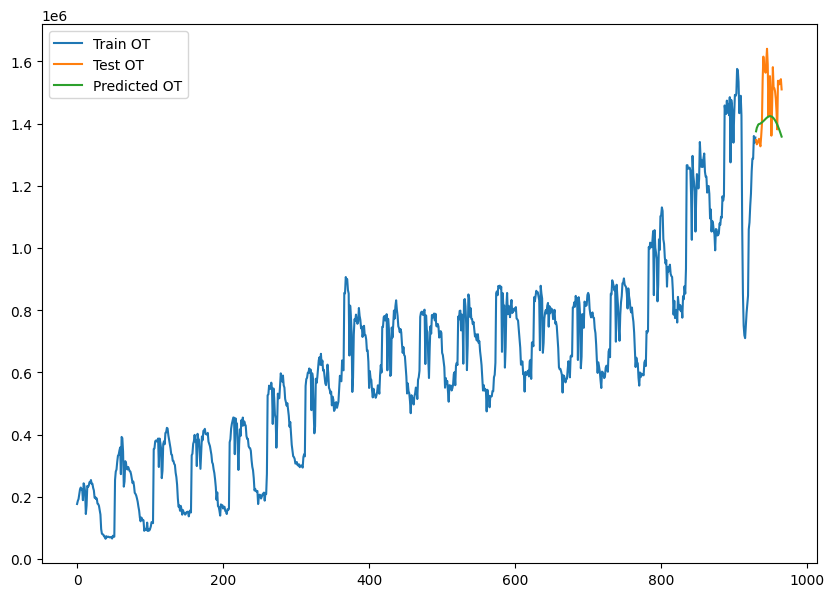

In [ ]:
plt.rcParams["figure.figsize"] = [10,7]
plt.plot(results['OT'][:-36], label='Train OT')
plt.plot(results['OT'][-36:], label='Test OT')
plt.plot(results['forecast_36'], label='Predicted OT')
plt.legend(loc='best')
plt.show()

In [ ]:
len(results['OT'][-48:])

48

In [ ]:
len(results['OT'][:-48])

918

In [ ]:
len(results['OT'])

966

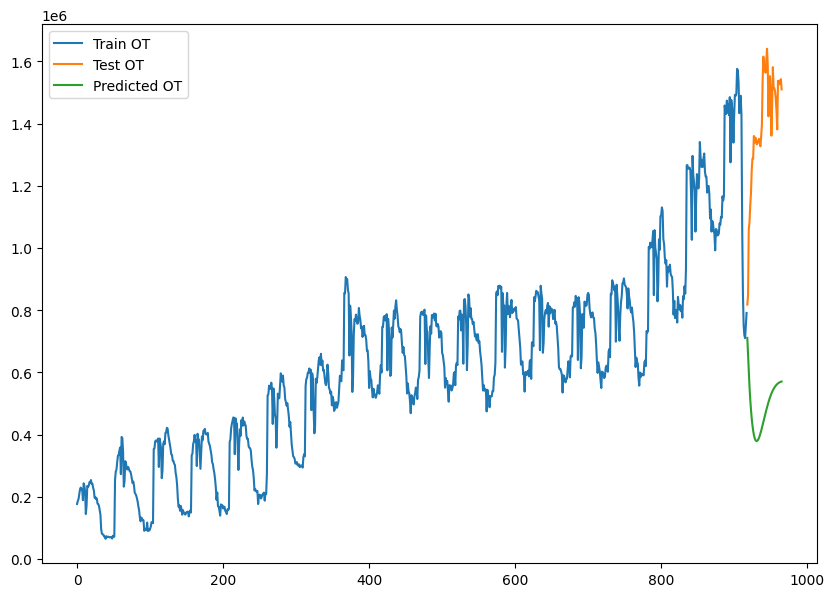

In [ ]:
plt.rcParams["figure.figsize"] = [10,7]
plt.plot(results['OT'][:-48], label='Train OT')
plt.plot(results['OT'][-48:], label='Test OT')
plt.plot(results['forecast_48'], label='Predicted OT')
plt.legend(loc='best')
plt.show()

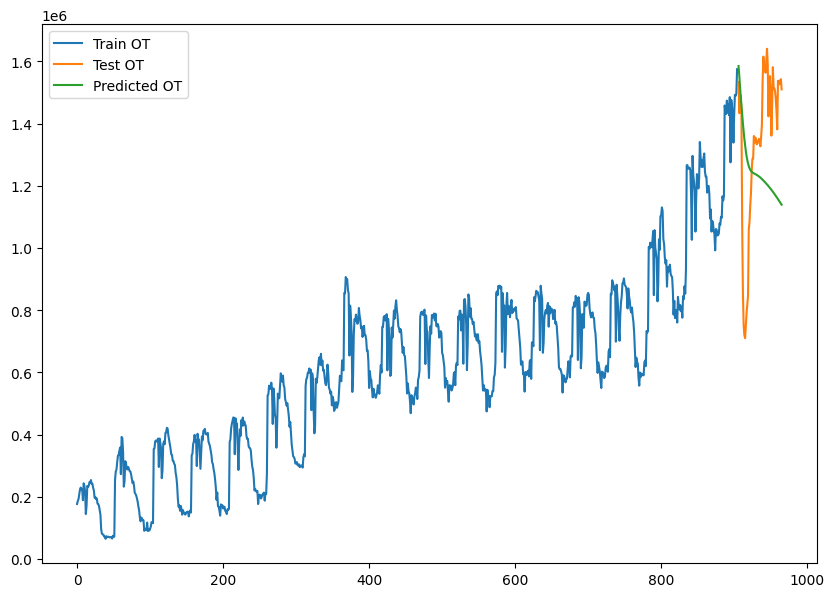

In [ ]:
plt.rcParams["figure.figsize"] = [10,7]
plt.plot(results['OT'][:-60], label='Train OT')
plt.plot(results['OT'][-60:], label='Test OT')
plt.plot(results['forecast_60'], label='Predicted OT')
plt.legend(loc='best')
plt.show()

# Old Code

In [ ]:
def find_order_auto_arima(X):
  print(f'Searching order of p and q for : OT')
  stepwise_model = auto_arima(X['OT'],start_p=1, start_q=1,max_p=7, max_q=7, seasonal=False,
      trace=True,error_action='ignore',suppress_warnings=True, stepwise=True,maxiter=1000)
  parameter = stepwise_model.get_params().get('order')
  print(f'optimal order for: OT is: {parameter} \n\n')
  return stepwise_model.get_params().get('order')

In [ ]:
def find_order_param_grid_diff(X, y):
  param_grid = {'p': [1,2,3], 'q':[1,2,3]}
  pg = list(ParameterGrid(param_grid))

  df_results = pd.DataFrame(columns=['p', 'q','mae','mse'])
  print('Starting grid search...')
  for a,b in enumerate(pg):
    p = b.get('p')
    q = b.get('q')
    if (p==2 and q==3):
      pass
    else:
      print(f'Order: p={p}, q={q}')
      model_fit = VARMAX(X, order=(p,q)).fit()
      result = model_fit.forecast(len(y))

      df_pred = pd.DataFrame(result, columns=train.columns)

      df_pred["new_index"] = range(len(X), len(df_raw))
      df_pred = df_pred.set_index("new_index")

      res = inverse_diff_func(X, df_pred)

      mae = mean_absolute_error(y['OT'] , res['OT_inv_diff'])
      mse = mean_squared_error(y['OT'], res['OT_inv_diff'])

      df_results = df_results.append({'p': p, 'q': q, 'mae': mae, 'mse': mse}, ignore_index=True)

  return list(df_results.sort_values('mae', ascending=True)[['p', 'q']].iloc[0])

In [ ]:
optimal_order1 = find_order_auto_arima(train_diff) 
optimal_order2 = find_order_param_grid_diff(train_diff, test) 
optimal_order3 = find_order_auto_arima(train) 
optimal_order4 = find_order_param_grid(train, test)  

In [ ]:
print(f'Order (AutoARIMA, difference): {optimal_order1}')
print(f'Order (GridSearch, difference): {optimal_order2}')
print(f'Order (AutoARIMA, non-difference): {optimal_order3}')
print(f'Order (GridSearch, non-difference): {optimal_order4}')

In [ ]:
model1 = VARMAX(train_diff, order=(optimal_order1[0], optimal_order1[2])).fit(disp=False)
model2 = VARMAX(train_diff, order=optimal_order2).fit(disp=False)
model3 = VARMAX(train, order=(optimal_order3[0], optimal_order1[2])).fit(disp=False)
model4 = VARMAX(train, order=optimal_order4).fit(disp=False)

In [ ]:
result3 = model3.forecast(steps = len(test))
result4 = model4.forecast(steps = len(test))

# Non-Difference
print(f'AutoARIMA:')
print(f'Evaluation metric for OT:')
timeseries_evaluation_metrics_func(test['OT'] , result3['OT'])

print(f'GridSearch:')
print(f'Evaluation metric for OT:')
timeseries_evaluation_metrics_func(test['OT'] , result4['OT'])

In [ ]:
# Difference 
df_pred1 = pd.DataFrame(result1, columns=train_diff.columns)
df_pred2 = pd.DataFrame(result2, columns=train_diff.columns)


df_pred1["new_index"] = range(len(train), len(X))
df_pred2["new_index"] = range(len(train), len(X))

df_pred1 = df_pred1.set_index("new_index")
df_pred2 = df_pred2.set_index("new_index")

res1 = inverse_diff_func(train, df_pred1)
res2 = inverse_diff_func(train, df_pred2)

print(f'AutoARIMA:')
print(f'Evaluation metric for OT:')
timeseries_evaluation_metrics_func(test['OT'] , res1['OT_inv_diff'])

print(f'GridSearch:')
print(f'Evaluation metric for OT:')
timeseries_evaluation_metrics_func(test['OT'] , res2['OT_inv_diff'])

In [ ]:
plt.rcParams["figure.figsize"] = [10,7]
plt.plot(train['OT'], label='Train OT')
plt.plot(test['OT'], label='Test OT')
plt.plot(res['OT_inv_diff'], label='Predicted OT')
plt.legend(loc='best')
plt.show()